# Approximate q-learning

In this notebook you will teach a __tensorflow__ neural network to do Q-learning.

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for tensorflow, but you will find it easy to adapt it to almost any python-based deep learning framework.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [3]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

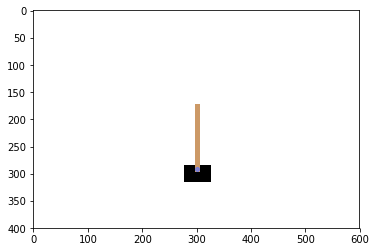

In [4]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Approximate (deep) Q-learning: building the network

To train a neural network policy one must have a neural network policy. Let's build it.


Since we're working with a pre-extracted features (cart positions, angles and velocities), we don't need a complicated network yet. In fact, let's build something like this for starters:

![img](https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/yet_another_week/_resource/qlearning_scheme.png)

For your first run, please only use linear layers (L.Dense) and activations. Stuff like batch normalization or dropout may ruin everything if used haphazardly. 

Also please avoid using nonlinearities like sigmoid & tanh: agent's observations are not normalized so sigmoids may become saturated from init.

Ideally you should start small with maybe 1-2 hidden layers with < 200 neurons and then increase network size if agent doesn't beat the target score.

In [6]:
import tensorflow as tf
keras = tf.keras
L = tf.keras.layers
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

In [11]:
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))
network.add(L.Dense(256))
network.add(L.ReLU())
network.add(L.Dense(256))
network.add(L.ReLU())
network.add(L.Dense(env.action_space.n))
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               1280      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 67,586
Trainable params: 67,586
Non-trainable params: 0
_________________________________________________________________


In [27]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]
    
    
    if np.random.rand() < epsilon:
        return np.random.choice(n_actions)
    else:
        return np.argmax(q_values)


In [28]:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

e=0.0 tests passed
e=0.1 tests passed


KeyboardInterrupt: 

### Q-learning via gradient descent

We shall now train our agent's Q-function by minimizing the TD loss:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$


Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

The tricky part is with  $Q_{-}(s',a')$. From an engineering standpoint, it's the same as $Q_{\theta}$ - the output of your neural network policy. However, when doing gradient descent, __we won't propagate gradients through it__ to make training more stable (see lectures).

To do so, we shall use `tf.stop_gradient` function which basically says "consider this thing constant when doingbackprop".

In [30]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
actions_ph = tf.placeholder('int32', shape=[None])
rewards_ph = tf.placeholder('float32', shape=[None])
next_states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
is_done_ph = tf.placeholder('bool', shape=[None])

In [31]:
#get q-values for all actions in current states
predicted_qvalues = network(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

In [50]:
gamma = 0.99

v_of_next_state = tf.stop_gradient(
    tf.reduce_max(network(next_states_ph), axis=-1)
)

v_of_next_state = (1. - tf.to_float(is_done_ph)) * v_of_next_state

temporal_difference = (predicted_qvalues_for_actions - (rewards_ph + gamma * v_of_next_state))
loss = tf.reduce_mean(temporal_difference ** 2)


In [51]:
# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

### Playing the game

In [52]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [53]:
epsilon = 0.5

In [54]:
sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.9
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break


epoch #0	mean reward = 13.970	epsilon = 0.500
epoch #1	mean reward = 13.570	epsilon = 0.450
epoch #2	mean reward = 12.880	epsilon = 0.405
epoch #3	mean reward = 13.080	epsilon = 0.365
epoch #4	mean reward = 12.610	epsilon = 0.328
epoch #5	mean reward = 14.420	epsilon = 0.295
epoch #6	mean reward = 14.310	epsilon = 0.266
epoch #7	mean reward = 23.250	epsilon = 0.239
epoch #8	mean reward = 30.180	epsilon = 0.215
epoch #9	mean reward = 55.760	epsilon = 0.194
epoch #10	mean reward = 40.000	epsilon = 0.174
epoch #11	mean reward = 90.460	epsilon = 0.157


### How to interpret results


Welcome to the f.. world of deep f...n reinforcement learning. Don't expect agent's reward to smoothly go up. Hope for it to go increase eventually. If it deems you worthy.

Seriously though,
* __ mean reward__ is the average reward per game. For a correct implementation it may stay low for some 10 epochs, then start growing while oscilating insanely and converges by ~50-100 steps depending on the network architecture. 
* If it never reaches target score by the end of for loop, try increasing the number of hidden neurons or look at the epsilon.
* __ epsilon__ - agent's willingness to explore. If you see that agent's already at < 0.01 epsilon before it's is at least 200, just reset it back to 0.1 - 0.5.

### Record videos

As usual, we now use `gym.wrappers.Monitor` to record a video of our agent playing the game. Unlike our previous attempts with state binarization, this time we expect our agent to act ~~(or fail)~~ more smoothly since there's no more binarization error at play.

As you already did with tabular q-learning, we set epsilon=0 for final evaluation to prevent agent from exploring himself to death.

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices